In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml2021spring-hw1/covid.test.csv
/kaggle/input/ml2021spring-hw1/sampleSubmission.csv
/kaggle/input/ml2021spring-hw1/covid.train.csv


In [2]:
!cat /kaggle/input/ml2021spring-hw1/sampleSubmission.csv |head -2

id,tested_positive
0,0.0


## 1. Handle Data


### 1.1 数据预处理并划分数据集

In [3]:
train_path = "/kaggle/input/ml2021spring-hw1/covid.train.csv"
test_path = "/kaggle/input/ml2021spring-hw1/covid.test.csv"

In [4]:
### handle train data
def load_data(path:str, train=True):
    data = pd.read_csv(path,)
    data = data.drop(['id'],axis = 1)
    return data.values.astype(float)

def normal(data, test = False, max_ = None, min_ = None):
    if not test:
        max_ = data.max(axis = 0)
        min_ = data.min(axis = 0)
    return (data-min_)/(max_ - min_),max_,min_

def shuffle(data,label):
    idxes = [i for i in range(data.shape[0])]
    np.random.shuffle(idxes)
    return data[idxes], label[idxes]

## 划分训练集和验证集
def split_data(data, label, rate = 0.7):
    data,label = shuffle(data,label)
    l = (int)(data.shape[0]*rate)
    return data[:l],data[l:],label[:l],label[l:]
    

In [5]:
# train data handle
train_data = load_data(train_path);
train_d, label = train_data[:,:-1],train_data[:,-1]
#print(label.shape[0],train_d.shape[0])
train_data, max_,min_ = normal(train_d)
#print(type(train_data))
train_data, dev_data, train_label,dev_label = split_data(train_d,label)
#print(train_label.shape,train_data.shape)

In [6]:
# test data handle
test_data = load_data(test_path)
#print(type(test_data))
test_data,_,_ = normal(test_data,True,max_,min_)
#print(type(test_data))

### 1.2 构建pytorch 数据集

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [8]:
class Covid19Dataset(Dataset):
    def __init__(self,data, label = None, test = True):
        # print(type(data),type(label))
        self.data = torch.from_numpy(data).float()
        if test:
            self.label = None
        else:
            self.label = torch.from_numpy(label).float()
        self.test = test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if self.test:
            return self.data[idx]
        else:
            return self.data[idx],self.label[idx]

In [9]:
batch_size = 128
training_data = Covid19Dataset(train_data,label,False)
deving_data = Covid19Dataset(dev_data,dev_label,False)
testing_data = Covid19Dataset(test_data)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(deving_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)

# 2. 构建网络模型

In [10]:
import torch.nn as nn

class Covid19Regressior(nn.Module):
    def __init__(self, input_size):
        super(Covid19Regressior, self).__init__()
        self.input_size = input_size
        self.func = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, X):
        return self.func(X).squeeze(1)
         

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [12]:
data_size, input_size = train_data.shape
model = Covid19Regressior(input_size)
model.to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 0.001
momentum = 0.8
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum = momentum)
epoches = 3000
model

Covid19Regressior(
  (func): Sequential(
    (0): Linear(in_features=93, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

### 2.1 训练网络

In [13]:
def dev(dev_dataloader,model,device,loss_fn):
    model.eval()
    all_dev_loss = 0.0
    for X,label in dev_dataloader:
        X,label = X.to(device),label.to(device)
        with torch.no_grad():
            dev_out = model(X)
            dev_loss = loss_fn(dev_out,label)
            all_dev_loss += dev_loss.detach().cpu().item()*len(X)
    all_dev_loss = all_dev_loss/len(dev_dataloader.dataset)
    return all_dev_loss
    

In [14]:
def predict(test_dataloader,model,device):
    model.eval()
    preds = []
    for X in test_dataloader:
        X = X.to(device)
        with torch.no_grad():
            dev_out = model(X)
            preds.append(dev_out.detach().cpu()) 
    preds = torch.cat(preds, dim=0).numpy() 
    return preds

In [15]:
from tqdm import tqdm
all_loss = {'train':[],'dev':[],'epoch':[]}
device_name = 'cpu'
early_stop = 200
early_stop_cnt = 0
min_loss = 100000
for epoch in range(epoches):
    model.train()
    for X, label in train_dataloader:
        # print(X.finfo,label.finfo)
        optimizer.zero_grad()
        X,label = X.to(device),label.to(device)
        out = model(X)
        loss = loss_fn(out,label)
        all_loss['train'].append(loss.detach().cpu().item())
        # all_loss.append(loss.detach().cpu().item())
        loss.backward()
        optimizer.step()
        device_name = X.device
    
    dev_loss = dev(dev_dataloader,model,device,loss_fn)

    if dev_loss < min_loss:
        all_loss['dev'].append(dev_loss)
        all_loss['epoch'].append(epoch)
        min_loss = dev_loss
        print(f"mode.device:{device_name}, epoch:{epoch}, loss:{min_loss}\n")
        early_stop_cnt = 0
    else:
        early_stop_cnt +=1
    
    if early_stop_cnt > early_stop:
        break;
print('Finished training after {} epochs'.format(epoch))

mode.device:cuda:0, epoch:0, loss:807.4767937713134

mode.device:cuda:0, epoch:1, loss:654.2910856912521

mode.device:cuda:0, epoch:2, loss:500.6625160000915

mode.device:cuda:0, epoch:3, loss:385.5575375633381

mode.device:cuda:0, epoch:4, loss:301.2409692427968

mode.device:cuda:0, epoch:5, loss:239.44100485541819

mode.device:cuda:0, epoch:6, loss:193.71720487357067

mode.device:cuda:0, epoch:7, loss:159.3782643460463

mode.device:cuda:0, epoch:8, loss:134.45046261412296

mode.device:cuda:0, epoch:9, loss:115.6563208658804

mode.device:cuda:0, epoch:10, loss:101.91206492507501

mode.device:cuda:0, epoch:11, loss:91.28081427784647

mode.device:cuda:0, epoch:12, loss:83.46408976638361

mode.device:cuda:0, epoch:13, loss:77.60695183468218

mode.device:cuda:0, epoch:14, loss:73.26162381060468

mode.device:cuda:0, epoch:15, loss:69.86996175857713

mode.device:cuda:0, epoch:16, loss:67.2500674133677

mode.device:cuda:0, epoch:17, loss:65.2274007832519

mode.device:cuda:0, epoch:18, loss:6

In [16]:
all_loss['dev']

[807.4767937713134,
 654.2910856912521,
 500.6625160000915,
 385.5575375633381,
 301.2409692427968,
 239.44100485541819,
 193.71720487357067,
 159.3782643460463,
 134.45046261412296,
 115.6563208658804,
 101.91206492507501,
 91.28081427784647,
 83.46408976638361,
 77.60695183468218,
 73.26162381060468,
 69.86996175857713,
 67.2500674133677,
 65.2274007832519,
 63.76793902076128,
 62.63595294129246,
 61.66802175594758,
 61.032921444179095,
 60.40205716792811,
 60.018764848626795,
 59.64014234437013,
 59.31420288838529,
 59.10092364404116,
 58.90471055563516,
 58.73778945038557,
 58.60850601102215,
 58.507398809957444,
 58.44897478341174,
 58.319690878382445,
 58.27265479091357,
 58.24563251500065,
 58.20699655554004,
 58.15518037958298,
 58.14551184356727,
 58.12900312731798,
 58.07275150736516,
 58.03528557341137,
 58.01529069893457,
 58.014293708283866,
 58.003090224636466,
 57.990368378588656,
 57.979094057283035,
 57.959632172684486,
 57.947245441441474,
 57.94428558914053,
 57.9431

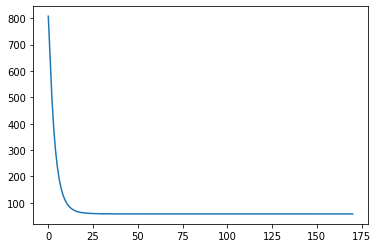

In [17]:
import matplotlib.pyplot as plt

plt.plot(all_loss['epoch'],all_loss['dev'])
plt.show()

### Predict

In [18]:
preds = predict(test_dataloader,model,device)

In [19]:
res = pd.DataFrame({'id':np.arange(len(preds)),'tested_positive':preds})

In [20]:
res.to_csv('pred.csv',index = False)
print("Finished !")

Finished !


In [21]:
!cat ./pred.csv|head -10

id,tested_positive
0,15.077124
1,15.062381
2,15.062459
3,15.0756445
4,15.080145
5,15.074683
6,15.066113
7,15.085552
8,15.075739


## Result

pred.csv
just now by hsjfans

second for gpu
7.94904
7.75425

pred.csv
14 minutes ago by hsjfans

finish hw1
7.94453
7.74895

